In [56]:
from random import randint

import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import Sequential
from keras.applications.densenet import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from tensorflow import keras

Your Client FinMan is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

## Erstelle aus `health-insurance.csv` einen DataFrame

In [57]:
insurance = pd.read_csv('./data/health-insurance.csv')

In [58]:
insurance.head(10)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
5,6,C9,1785,Rented,Individual,52,52,No,X2,5.0,1.0,22,15264.0,1
6,7,C3,679,Owned,Individual,28,28,No,NaN,NaN,NaN,17,10640.0,0
7,8,C1,3175,Owned,Joint,75,73,Yes,X4,9.0,4.0,17,29344.0,1
8,9,C15,3497,Owned,Joint,52,43,No,X1,14.0,3.0,1,27283.2,0
9,10,C1,530,Owned,Joint,59,26,Yes,NaN,7.0,4.0,18,21100.8,1


## Data Cleaning

* fehlende `Holding_Policy_Duration`/`Holding_Policy_Duration`-Werte sind gleich viele, sollten also gleich behandelt werden
* betrachte die Ausprägungen von `Health Indicator`. Auch hier gibt es einige `NaN`s

In [59]:
#insurance.rename(columns={"Health Indicator": "HealthIndicator"})

insurance.Health_Indicator.unique()


array(['X1', 'X2', nan, 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'],
      dtype=object)

In [60]:
insurance= insurance.drop(columns=["ID"])
insurance = pd.get_dummies(data=insurance, columns=['Health_Indicator','Reco_Insurance_Type','Accomodation_Type','Is_Spouse','City_Code','Holding_Policy_Duration'])


In [61]:
 insurance.fillna(insurance.mean(),inplace=True)

## Training
* 20% Testdaten
* `random_state=42` sofern unterstützt
* target feature: `Response`
* Überlege, welche Metrik maximiert werden soll (*accuracy*/*recall*/*f1*) und was die Business Implikation des erhaltenen Modells ist, diese Metrik geht in die `GridSearchCV` als `scoring` ein
* Trainiere mindestens
    * eine optimierte `LogisticRegression` mit `GridSearchCV` (optimiere `solver`, `C` und `class_weight`)
    * einen optimierten `RandomForestClassifier`
    * zwei ANNs (eins mit `class_weights` und eins ohne).
        `compile(metrics=[<metrik>]` kann entweder ein String übergeben werden oder eine Instanz einer Klasse aus `keras.metrics`

In [62]:
##precision maximieren

X = insurance.drop(columns='Response')
y = insurance.Response

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
log_reg_cv = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'solver': ['sag', 'saga', 'newton-cg', 'lbfgs'],
        'class_weight': [None, 'balanced'],
        'C': [1.0]  #inverse Regularization
    },
    n_jobs=2,
    scoring='precision',
    cv=5,
)
log_reg_cv.fit(X_train, y_train)
log_reg_cv.score(X_test, y_test)
#precision 0.2716902868994124
#accuracy 0.7554289083226884
#recall 0.631578947368421

0.2716902868994124

In [64]:
forest_cv = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions={
        'n_estimators': range(50,400,50),
        'max_features': [1.0, 'sqrt', 'log2'],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    },
    n_jobs=2,
    scoring='precision',
    cv=3,
 #   n_iter=20,
)
forest_cv.fit(X_train, y_train)
forest_cv.score(X_test, y_test)
#accuracy 0.459214501510574
#precision 0.4725609756097561
#recall 0.45329249617151607


0.463452566096423

Epoch 1/90
1273/1273 [==============================] - 3s 2ms/step - loss: 0.5493 - precision: 0.2455 - val_loss: 0.5478 - val_precision: 0.0000e+00
Epoch 2/90
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5401 - precision: 0.0000e+00 - val_loss: 0.5468 - val_precision: 0.0000e+00
Epoch 3/90
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5380 - precision: 0.0000e+00 - val_loss: 0.5475 - val_precision: 0.0000e+00
Epoch 4/90
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5362 - precision: 0.0000e+00 - val_loss: 0.5452 - val_precision: 0.0000e+00
Epoch 5/90
1273/1273 [==============================] - 2s 1ms/step - loss: 0.5344 - precision: 0.0000e+00 - val_loss: 0.5445 - val_precision: 0.0000e+00
Epoch 6/90
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5328 - precision: 1.0000 - val_loss: 0.5455 - val_precision: 0.0000e+00
Epoch 7/90
1273/1273 [==============================] - 2s 2ms/step - loss: 0.5315 -

<AxesSubplot:>

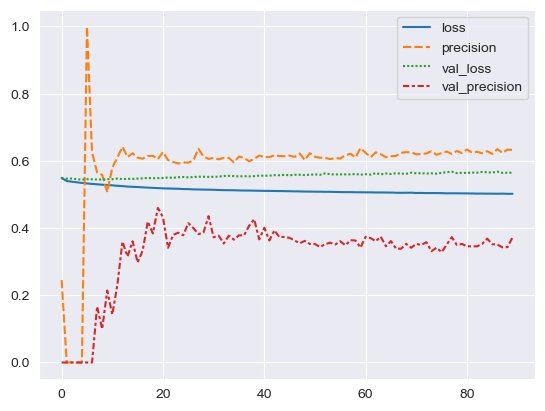

In [65]:
# without class weights
ann = Sequential([
    layers.Dense(units=20, activation='relu', dtype='float64'),
    layers.Dense(units=10, activation='relu', dtype='float64'),
    layers.Dense(units=1, activation='sigmoid', dtype='float64'),
])

ann.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics='Precision')

history = ann.fit(X_train,
                  y_train,
                  batch_size=32,
                  validation_data=(X_test, y_test),
                  epochs=90,
                  verbose=1,
                  )
sns.lineplot(data=history.history)

In [66]:

class_weights = dict(zip([0, 1], insurance.Response.value_counts().sum() / insurance.Response.value_counts()))
ann_with_class_weights = Sequential([
        layers.Dense(units=20, activation='relu', dtype='float64'),
        layers.Dense(units=10, activation='relu', dtype='float64'),
        layers.Dense(units=1, activation='sigmoid', dtype='float64'),
    ])

ann_with_class_weights.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics='Precision')


Epoch 1/90
1273/1273 [==============================] - 5s 3ms/step - loss: 1.3682 - precision: 0.2604 - val_loss: 0.6672 - val_precision: 0.2696
Epoch 2/90
1273/1273 [==============================] - 2s 2ms/step - loss: 1.3508 - precision: 0.2670 - val_loss: 0.6833 - val_precision: 0.2726
Epoch 3/90
1273/1273 [==============================] - 3s 2ms/step - loss: 1.3437 - precision: 0.2729 - val_loss: 0.6826 - val_precision: 0.2749
Epoch 4/90
1273/1273 [==============================] - 2s 2ms/step - loss: 1.3386 - precision: 0.2762 - val_loss: 0.6798 - val_precision: 0.2755
Epoch 5/90
1273/1273 [==============================] - 2s 2ms/step - loss: 1.3343 - precision: 0.2810 - val_loss: 0.6685 - val_precision: 0.2823
Epoch 6/90
1273/1273 [==============================] - 2s 2ms/step - loss: 1.3296 - precision: 0.2850 - val_loss: 0.6706 - val_precision: 0.2835
Epoch 7/90
1273/1273 [==============================] - 2s 2ms/step - loss: 1.3257 - precision: 0.2882 - val_loss: 0.6842 - 

<AxesSubplot:>

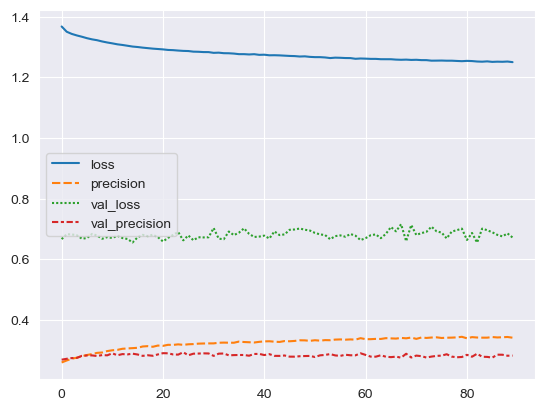

In [67]:

history_with_class_weights = ann_with_class_weights.fit(X_train,
                                     y_train,
                                     batch_size=32,
                                     validation_data=(X_test, y_test),
                                     epochs=90,
                                     verbose=1,
                                     class_weight=class_weights,
                                     )

sns.lineplot(data=history_with_class_weights.history)

In [68]:
from sklearn.metrics import classification_report

print(classification_report(y_test, ann_with_class_weights.predict(X_test) > 0.5))

319/319 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.60      0.68      7688
           1       0.28      0.48      0.36      2489

    accuracy                           0.57     10177
   macro avg       0.53      0.54      0.52     10177
weighted avg       0.66      0.57      0.60     10177



In [69]:
print(classification_report(y_test, ann.predict(X_test) > 0.5))

319/319 [==============================] - 0s 981us/step
              precision    recall  f1-score   support

           0       0.76      0.97      0.85      7688
           1       0.37      0.06      0.10      2489

    accuracy                           0.75     10177
   macro avg       0.57      0.51      0.47     10177
weighted avg       0.67      0.75      0.67     10177



In [70]:
# ann.compile(optimizer='adam',
#             loss='binary_crossentropy',
#             metrics='Precision')
#
# history = ann.fit(X_train,
#                   y_train,
#                   batch_size=32,
#                   validation_data=(X_test, y_test),
#                   epochs=90,
#                   verbose=1,
#                   )
#
# ann_with_class_weights.compile(optimizer='adam',
#                                loss='binary_crossentropy',
#                                metrics='Precision')
#
# history_with_class_weights = ann_with_class_weights.fit(X_train,
#                                                         y_train,
#                                                         batch_size=32,
#                                                         validation_data=(X_test, y_test),
#                                                         epochs=90,
#                                                         verbose=1,
#                                                         class_weight=class_weights,
#                                                         )

In [71]:
# print(classification_report(y_test, ann_with_class_weights.predict(X_test) > 0.5))
#
#

In [72]:
# print(classification_report(y_test, ann.predict(X_test) > 0.5))

## Evaluiere die Modelle und Interpretiere deine Lösung bezüglich *precision*/*recall*/*f1*

In [72]:
#Das Ziel war  die Precision zu verbessern
# Sprich die Vorhersage, mit der ein Kunde tatsächlich eine Gesundheitsversicherung abschließen würde

#LogisticRegression
# hat eine Precision-Score von 0.2716902868994124
# schneidet schlechter als das RandomForestClassifier-Modell ab

#RandomForestClassifier
# hat eine Precision-Score von 0.4725609756097561

#ANN ohne weights
# hat eine schlechtere Precision als die Variante mit weights (0.28)
# Die Gefahr für mehr false positives ist bei diesem Modell somit größer
# False Positives sollten für eine gute Precision unbedingt vermieden werden

#ANN mit weights
# Hat eine Predicition von 0.37
# Somit das bessere Modell
